# GARCH Model -> volatility 결측치 처리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# fig
figsize=(15,5)
import seaborn as sns
import matplotlib.dates as mdates
import arch
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../data/BIT_2023_1차.csv')
df.head(3)

,time,Open,High,Low,Close,Volume,returns,volatility,price,quote_qty,is_buyer_maker,quote_qty_cal
0,2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399,NaN,NaN,16524.525741,7264.129209,16494,8.892507e+07
1,2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826,0.001416,NaN,16537.215985,6819.889969,8705,5.309812e+07
2,2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668,-0.000483,NaN,16545.818136,6030.420093,8468,3.970447e+07


In [3]:
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)

In [4]:
df.isnull().sum()

Open               24
High               24
Low                24
Close              24
Volume              0
returns            12
volatility        186
price              24
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

## 스플라인 보간

In [5]:
def spline_interpolate_column(df, column_name, order=3):
    df[column_name] = df[column_name].interpolate(method='spline', order=order)

In [6]:
columns_to_interpolate = ['Open', 'High', 'Low', 'Close','price']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

In [7]:
columns_to_interpolate_volume = ['quote_qty','quote_qty_cal']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=2)

In [8]:
columns_to_interpolate_volume = ['returns','volatility']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=2)

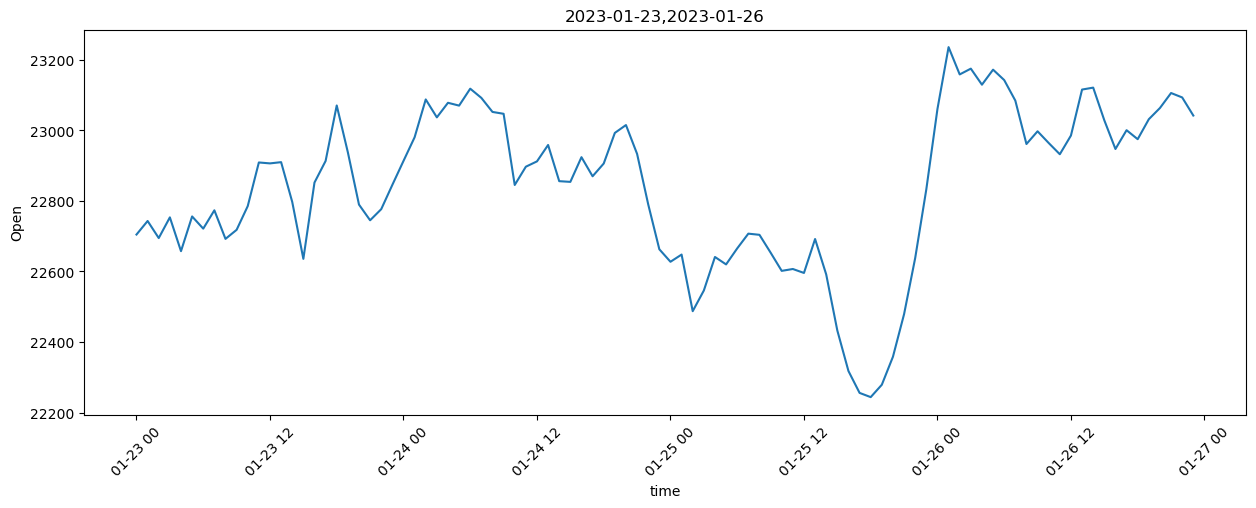

In [9]:
# 날짜 범위 선택
start_date = '2023-01-23'
end_date = '2023-01-26'
df_filtered = df.loc[start_date:end_date]

# 플롯 그리기
plt.figure(figsize=figsize)
plt.plot(df_filtered.index, df_filtered['Open'])
plt.xlabel('time')
plt.ylabel('Open')
plt.title('2023-01-23,2023-01-26')
plt.xticks(rotation=45)
plt.show()

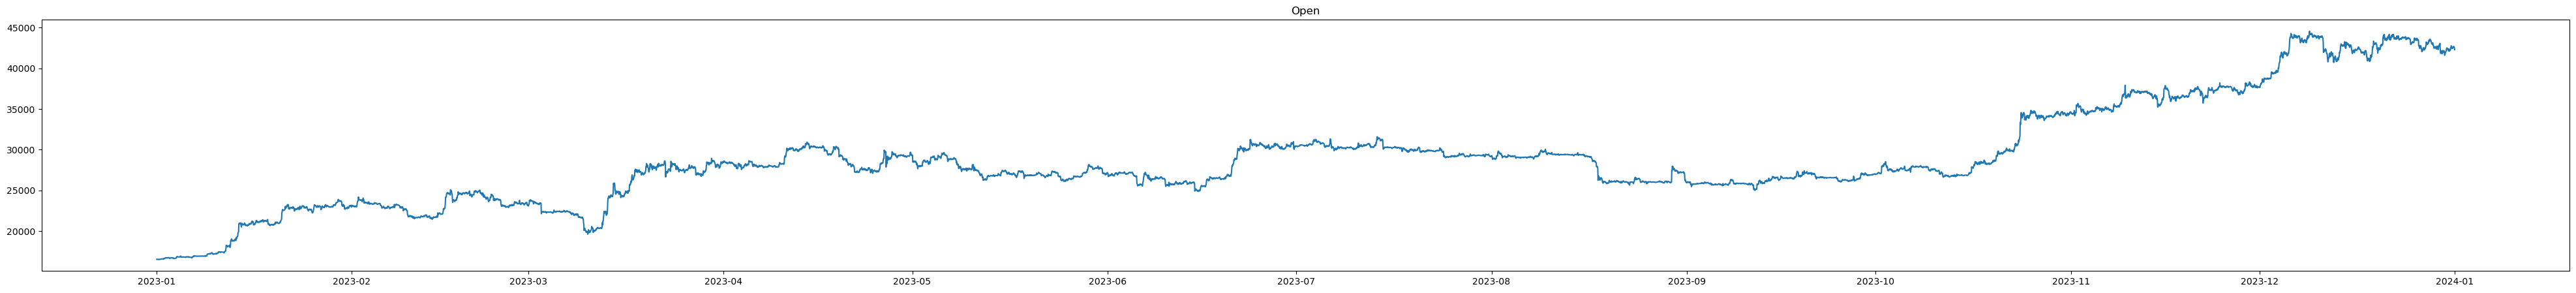

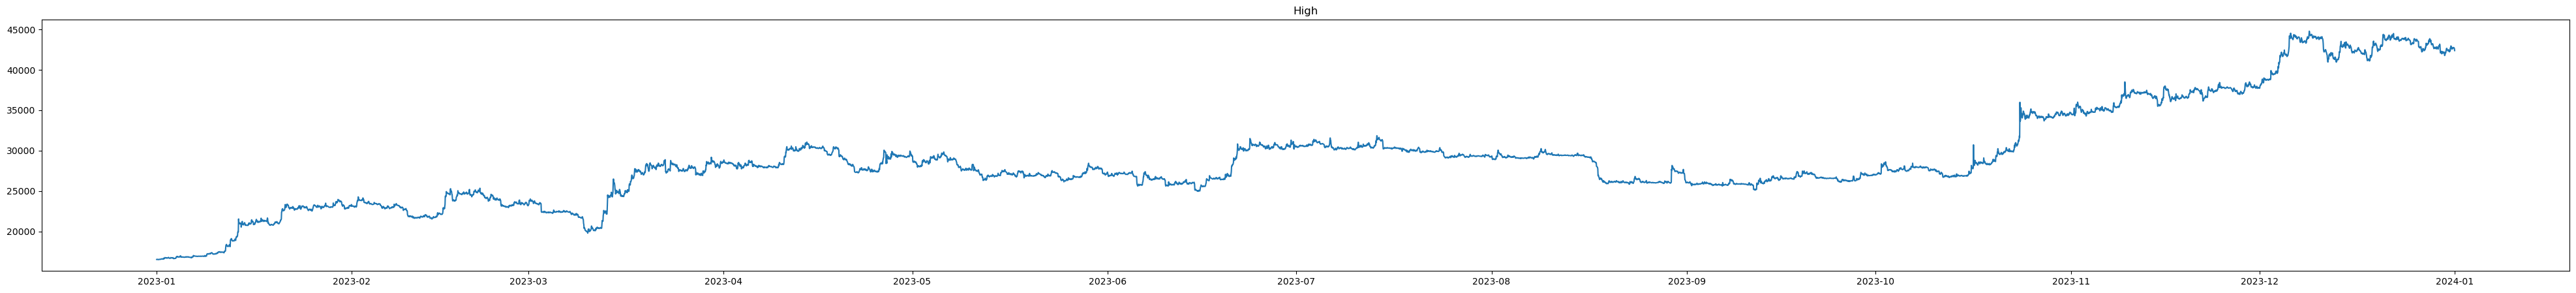

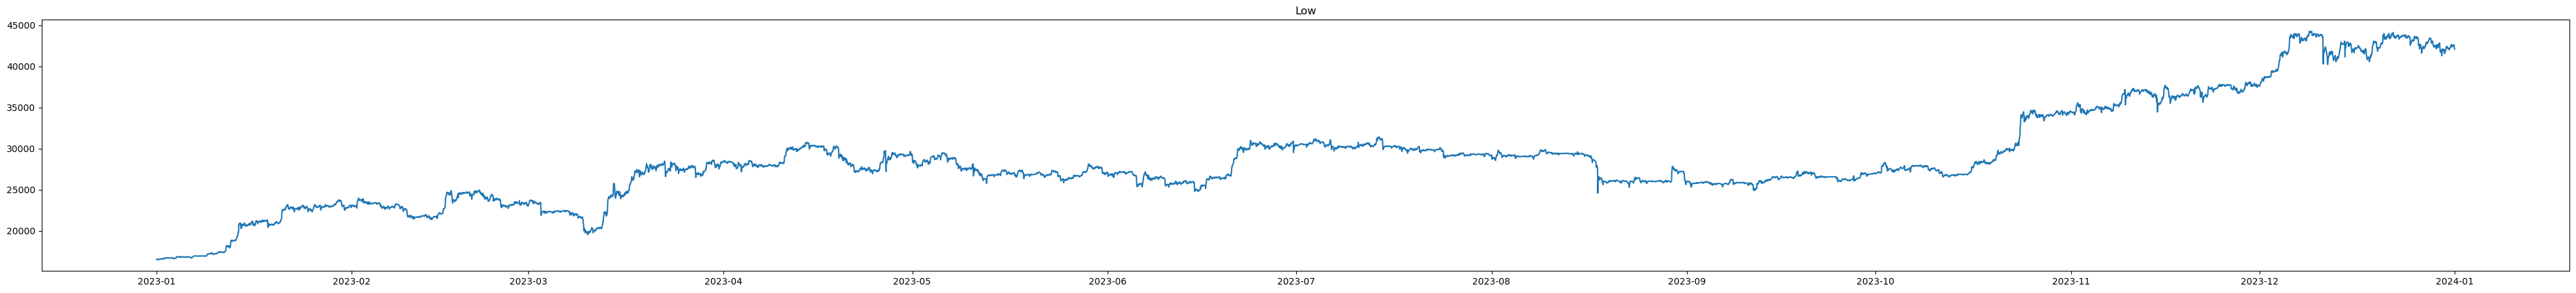

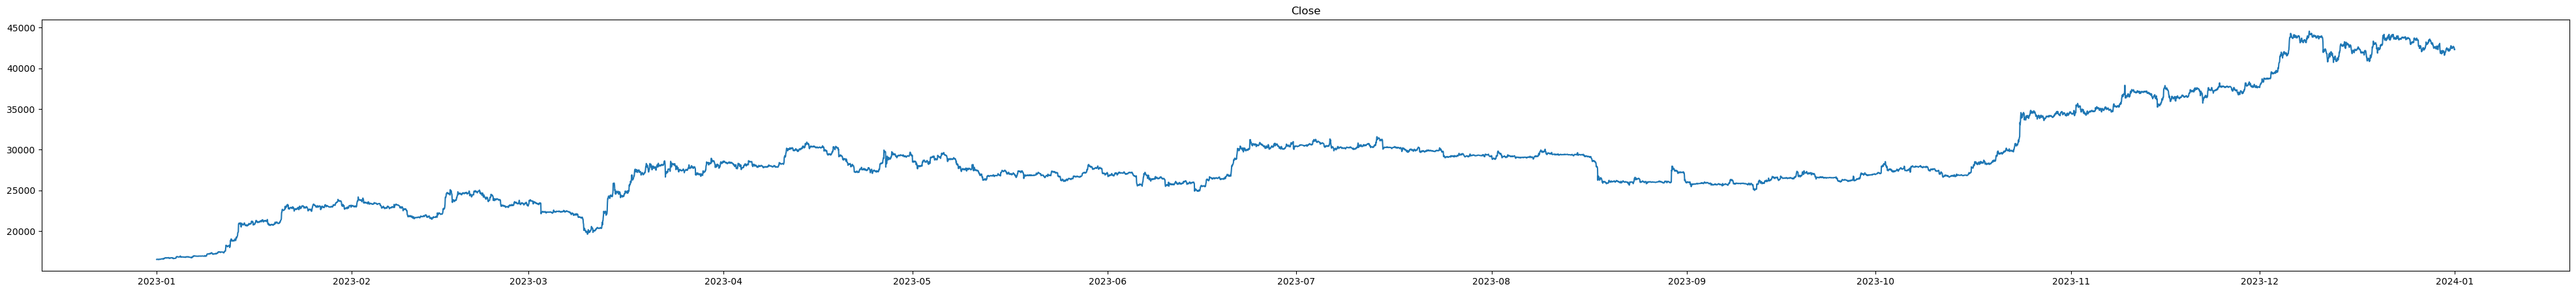

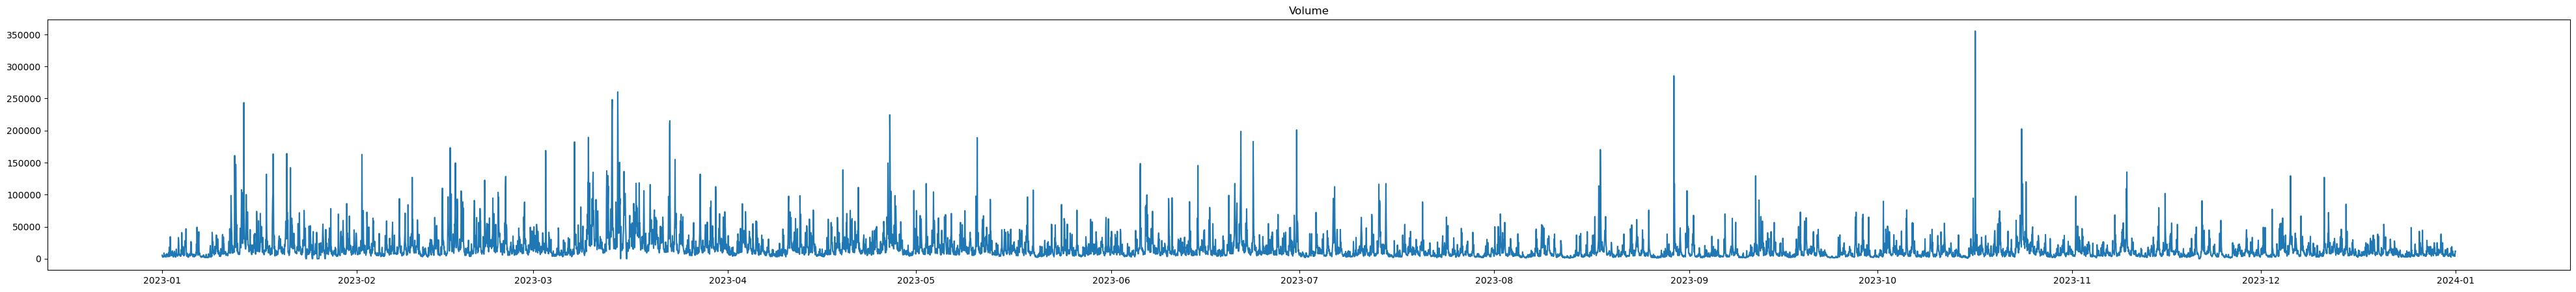

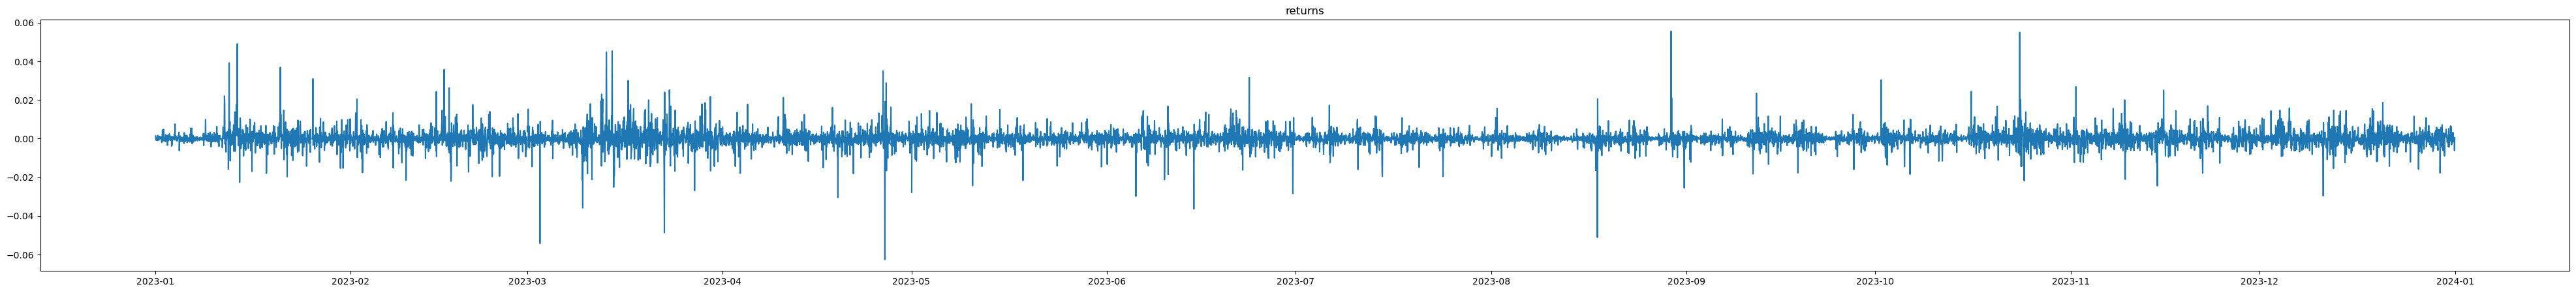

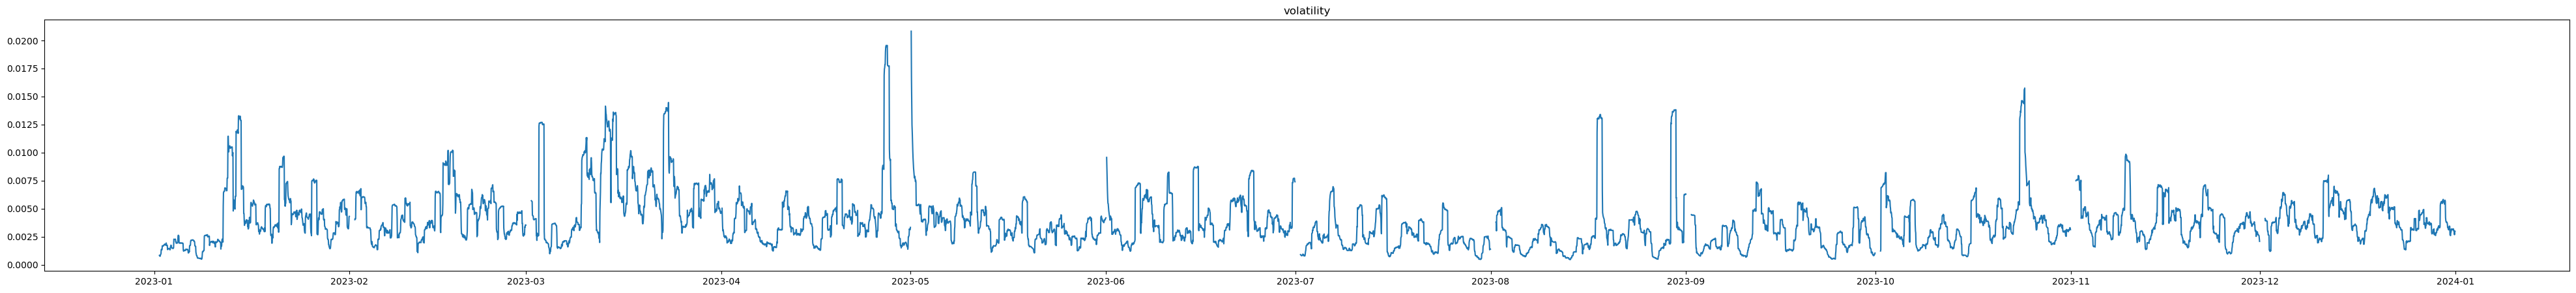

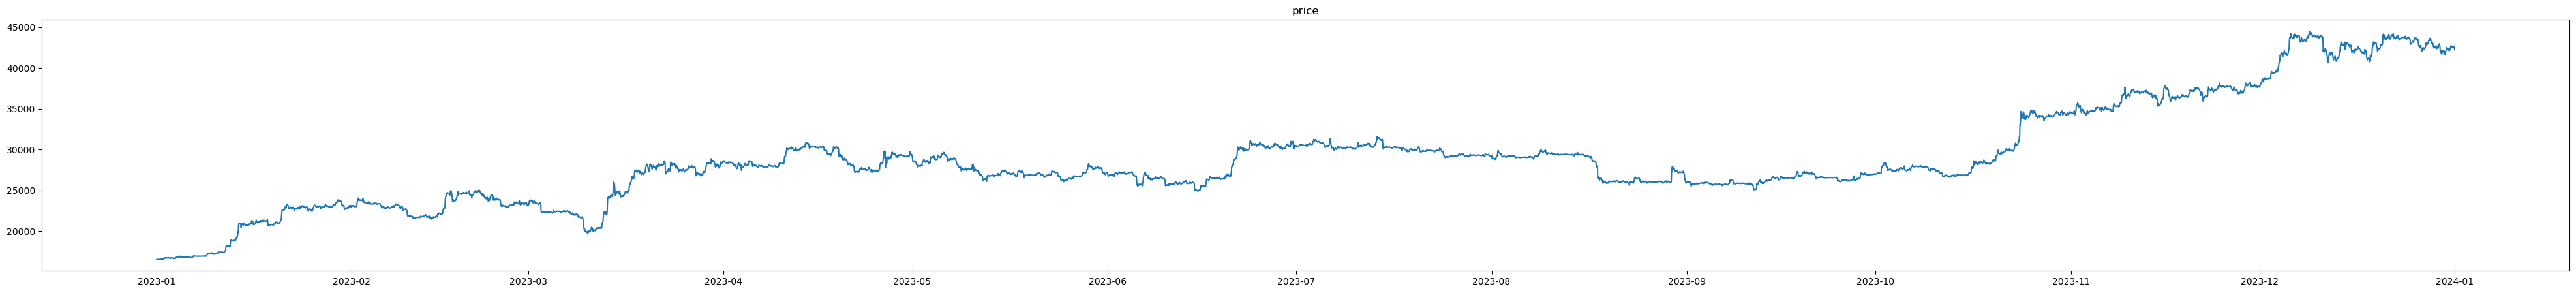

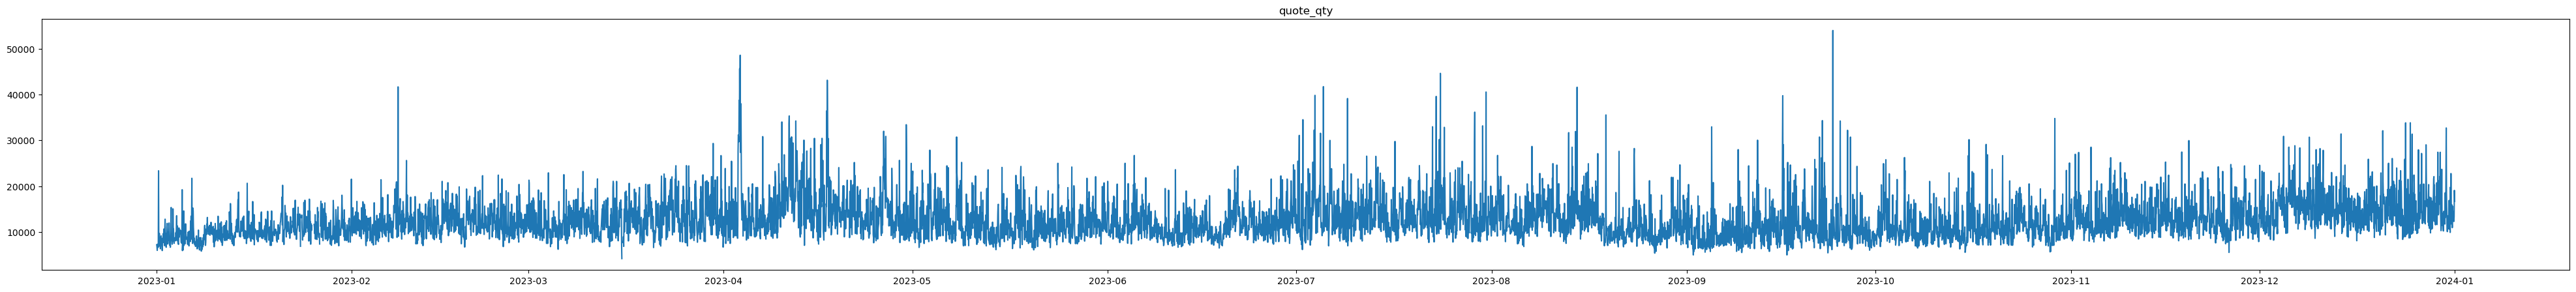

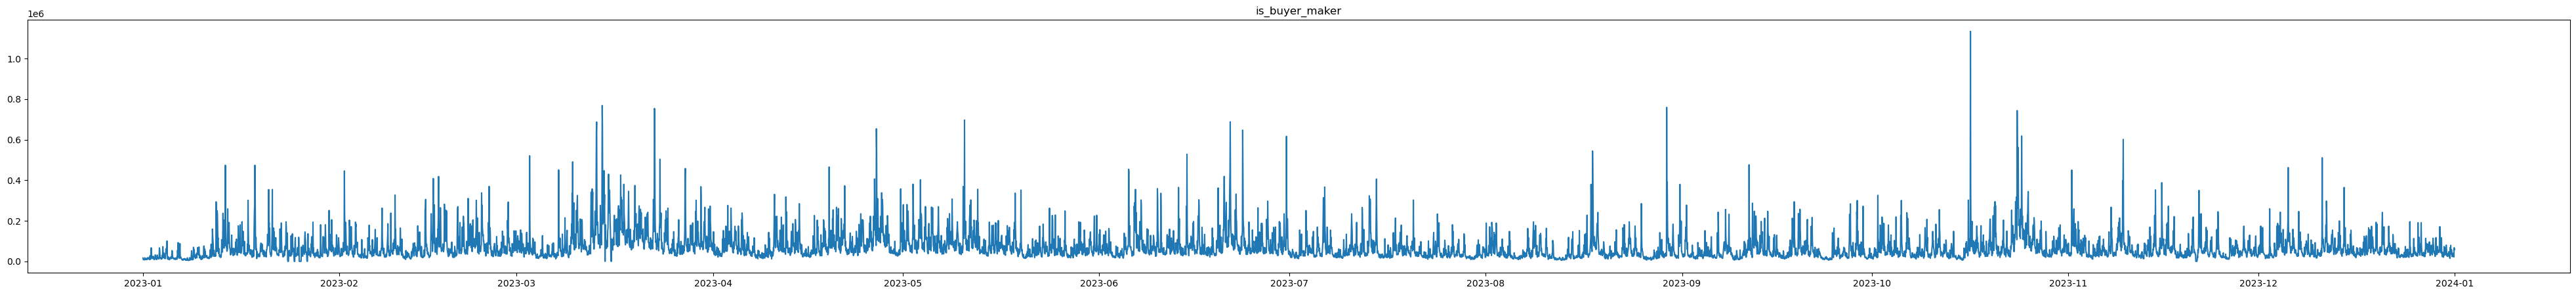

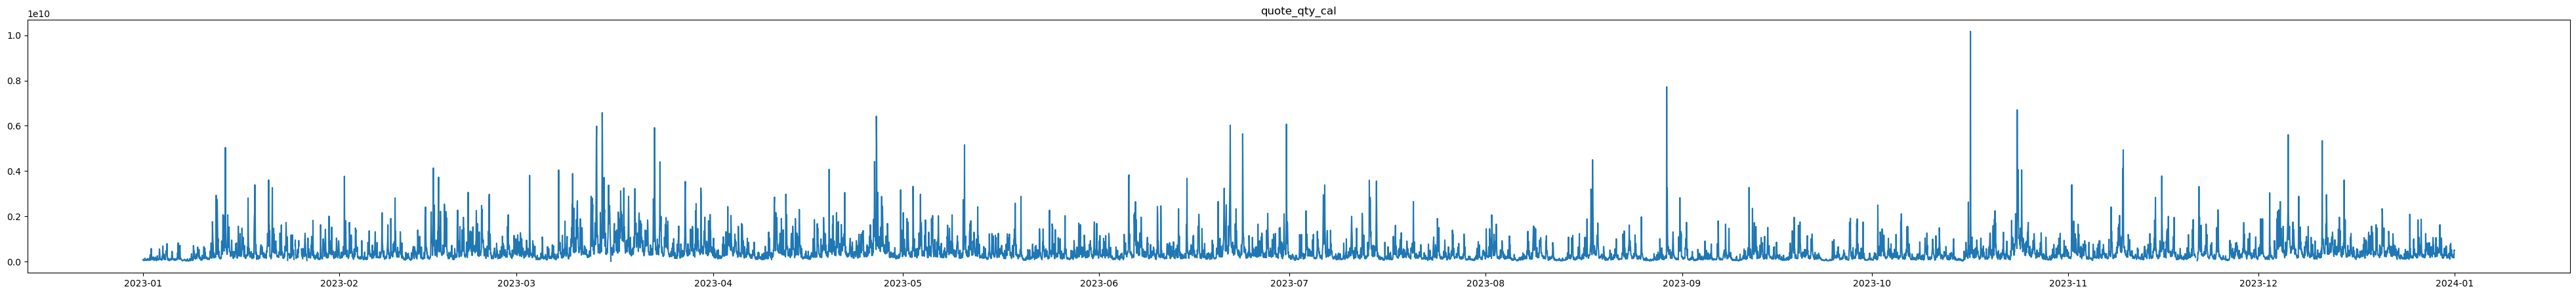

In [10]:
def Graph(data):
    for i, col in enumerate(data.columns):
        
        plt.figure(figsize=(50, 5))
        plt.plot(data.iloc[:,i])
        plt.title(f'{data.columns[i]}')
        
        # x축에 년도별 간격 표시
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
Graph(df)

# GARCH 모델

- 이거 오류 해결 오래 걸렸어요.. 검색해서 뒤져본 결과 pip install -U numba 하셔야 해요!!

https://stackoverflow.com/questions/74947992/how-to-remove-the-error-systemerror-initialization-of-internal-failed-without

In [11]:
df['volatility'].isna().sum()

186

In [12]:
df.isnull().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
returns            12
volatility        186
price               0
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

# 보간

In [29]:
returns = df['volatility']

# GARCH 모델 - 결측치 보간
interpolated_returns = returns.interpolate(method='linear')

# 보간된 결측치 - 원래의 데이터에 적용
df['volatility'] = interpolated_returns

In [30]:
df['volatility'].isna().sum()

20

- 결측치가 20개가 남는다.

In [33]:
# 결측치 인덱스 추출
missing_indices = returns[returns.isna()].index
missing_indices

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [39]:
# 결측치 이전까지의 데이터 사용 - GARCH 모델 적합
model = arch.arch_model(returns.dropna(), vol='Garch', p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -44373.95581358431
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -44373.95591050002
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.812e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [37]:
# 결측치 예측
forecasted_values = model_fit.forecast(start=missing_indices[0], horizon=len(missing_indices))

In [38]:
# 예측값을 결측치 위치에 대입하여 보간
predicted_values = forecasted_values.mean.iloc[-1].values
returns.loc[missing_indices] = predicted_values

C:\Users\jwoo\AppData\Local\Temp/ipykernel_11412/4165413974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns.loc[missing_indices] = predicted_values


In [40]:
# 보간된 결과를 확인
print(returns)

time
2023-01-01 00:00:00    0.003897
2023-01-01 01:00:00    0.003897
2023-01-01 02:00:00    0.003897
2023-01-01 03:00:00    0.003897
2023-01-01 04:00:00    0.003897
                         ...   
2023-12-31 19:00:00    0.003040
2023-12-31 20:00:00    0.002863
2023-12-31 21:00:00    0.002673
2023-12-31 22:00:00    0.003008
2023-12-31 23:00:00    0.002975
Name: volatility, Length: 8760, dtype: float64


In [41]:
df['volatility'].isna().sum()

0

- 결측치 0개 확인

# 2. 모델 생성 & 1. 최적화

p와 q는 GARCH(p, q) 모델의 차수
   
- GARCH(p, q) 모델은 자기회귀 조건부 헤테로스케딩성(autoregressive conditional heteroskedasticity, ARCH) 모델의 확장된 형태. ARCH 모델은 과거 오차 제곱값을 사용하여 조건부 분산을 모델링하는데, GARCH 모델은 이러한 ARCH 모델에 추가적으로 과거 조건부 분산 값을 사용하여 조건부 분산을 예측.
   
- p는 ARCH(p) 모델에서 사용되는 과거 오차 제곱값의 개수를 나타내며, q는 GARCH(q) 모델에서 사용되는 과거 조건부 분산 값의 개수. 
- 이 두 개수는 모델이 현재의 조건부 분산을 예측하는 데 얼마나 많은 이전 값들을 고려할지 결정하는 역할
   
- 일반적으로, p와 q는 시계열 데이터의 특성에 따라 조정. 더 복잡한 변동성 패턴을 모델링하려면 더 큰 p와 q 값을 선택할 수 있다. 하지만 너무 큰 값을 선택하면 모델이 과적합되거나 계산상의 문제가 발생할 수 있다. 따라서 적절한 p와 q 값을 선택하기 위해서는 데이터의 특성과 모델의 성능을 평가
   
> model = arch.arch_model(returns, vol='Garch', p=1, q=1)에서 p=1은 ARCH(1) 모델을, q=1은 GARCH(1) 모델을 의미. 이는 과거 1개의 오차 제곱값과 1개의 조건부 분산 값을 사용하여 현재의 조건부 분산을 모델링하는 것을 의미.

- 만약 다른 p와 q 값을 선택하고 싶다면, 해당 값을 변경하여 모델을 생성할 수 있다

In [67]:
import itertools
import warnings
import arch

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 데이터 및 모델 정의
best_aic = float("inf")
best_bic = float("inf")
best_p = 0
best_q = 0

# p와 q의 후보값 설정
p_values = range(0, 5)  # p의 후보값 (0~4)
q_values = range(0, 5)  # q의 후보값 (0~4)

# 그리드 탐색
for p, q in itertools.product(p_values, q_values):
    try:
        model = arch.arch_model(returns, vol="Garch", p=p, q=q)
        model_fit = model.fit(disp="off")
        aic = model_fit.aic
        bic = model_fit.bic
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_q = q
        if bic < best_bic:
            best_bic = bic
            best_p = p
            best_q = q
    except:
        continue

# 최적의 p와 q 값 출력
print("AIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
print("BIC를 기준으로 최적의 p와 q 값:", best_p, best_q)

C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-package

AIC를 기준으로 최적의 p와 q 값: 1 1
BIC를 기준으로 최적의 p와 q 값: 1 1


C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-package

- 최적의 p와 q는 1, 1

In [45]:
# GARCH 모델 생성 및 최적화
model = arch.arch_model(returns, vol='Garch', p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -44373.95581358431
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -44373.95591050002
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.812e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jwoo\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [46]:
# 최적화된 파라미터 출력
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                44374.0
Distribution:                  Normal   AIC:                          -88739.9
Method:            Maximum Likelihood   BIC:                          -88711.6
                                        No. Observations:                 8760
Date:                Wed, Jan 24 2024   Df Residuals:                     8759
Time:                        23:21:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.8971e-03  4.233e-09  9.208e+05      0.000 [3.

> 파라미터 추정에 robust 공분산 추정 방법이 사용되었음

1. Coefficients: GARCH 모델의 각 계수에 대한 추정치
- 주로 'const', 'omega', 'alpha', 'beta' 등의 계수가 포함
- 이 값들은 GARCH 모델의 파라미터 값
   
2. Standard Errors: 추정된 파라미터의 표준 오차
- 파라미터의 추정 정확성을 판단하는 데 도움이 된다
- 작은 표준 오차는 추정된 파라미터가 더 신뢰할 수 있다는 것
   
3. t-Values: 추정된 파라미터의 t-값
- t-값은 추정된 파라미터가 통계적으로 유의한지를 판단하는 데 사용
- 일반적으로 t-값이 1.96보다 크면 해당 파라미터가 통계적으로 유의하다고 간주
   
4. P-values: 추정된 파라미터의 p-값
- p-값은 추정된 파라미터가 유의한지를 판단하는 데 사용
- 일반적으로 p-값이 0.05보다 작으면 해당 파라미터가 통계적으로 유의하다고 간주

In [47]:
# 모델 시뮬레이션
nobs = len(returns)
simulated_data = model_fit.conditional_volatility[-nobs:] * np.random.normal(0, 1, nobs)

# 시뮬레이션 결과 출력
print(simulated_data)

time
2023-01-01 00:00:00    0.001733
2023-01-01 01:00:00    0.000834
2023-01-01 02:00:00    0.000524
2023-01-01 03:00:00    0.000703
2023-01-01 04:00:00   -0.001349
                         ...   
2023-12-31 19:00:00    0.001297
2023-12-31 20:00:00   -0.001280
2023-12-31 21:00:00    0.001990
2023-12-31 22:00:00    0.000091
2023-12-31 23:00:00    0.001570
Name: cond_vol, Length: 8760, dtype: float64


# 3. 시각화

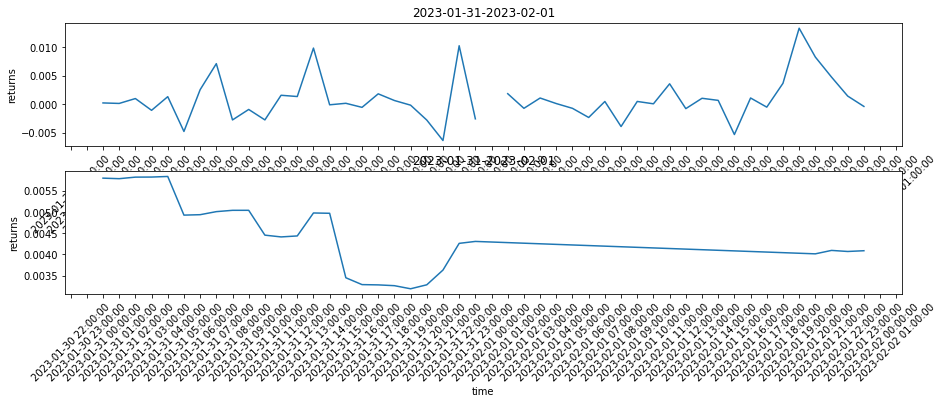

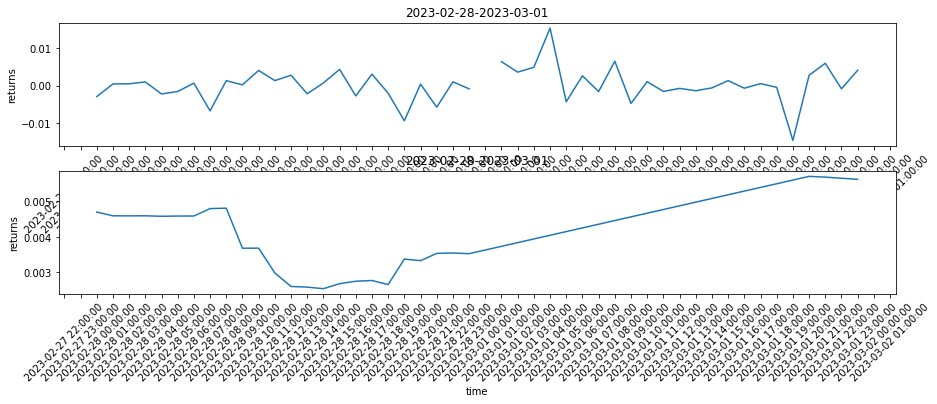

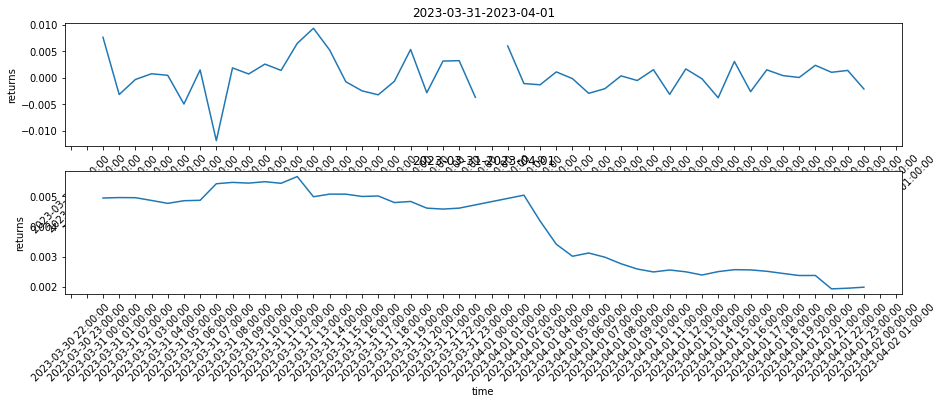

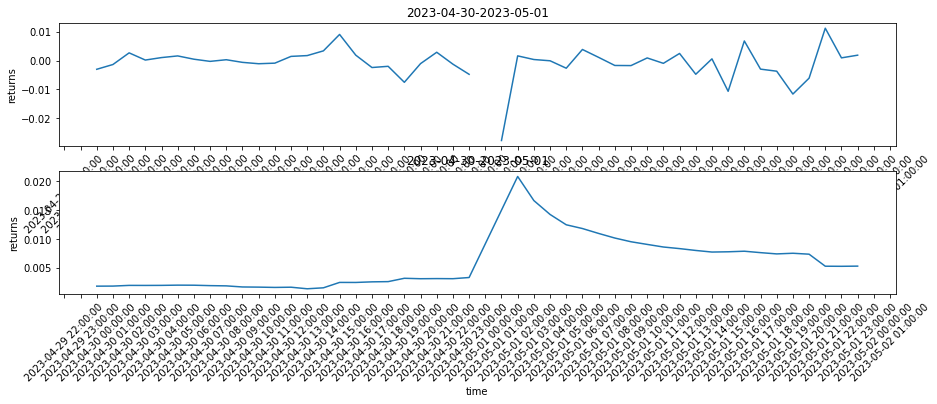

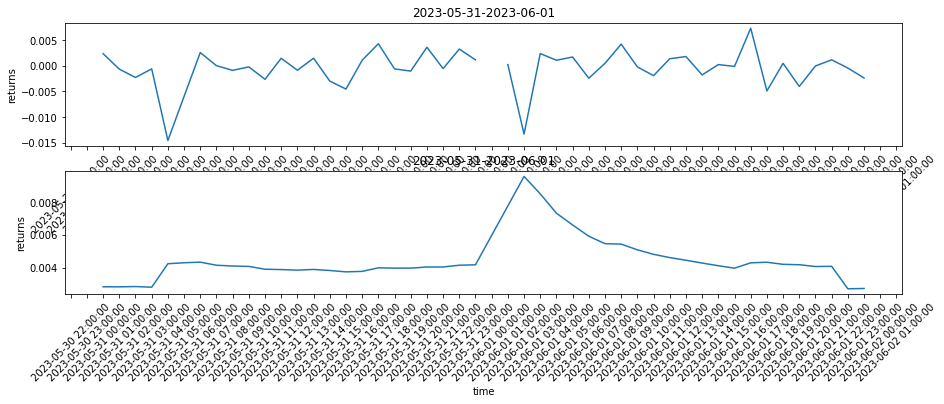

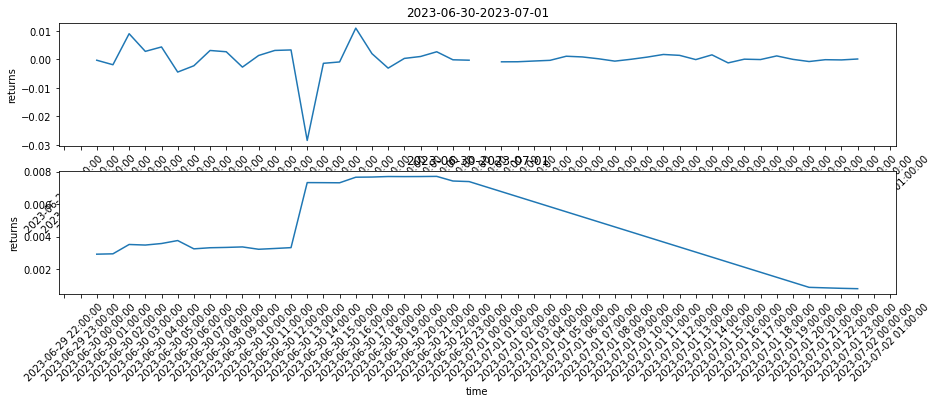

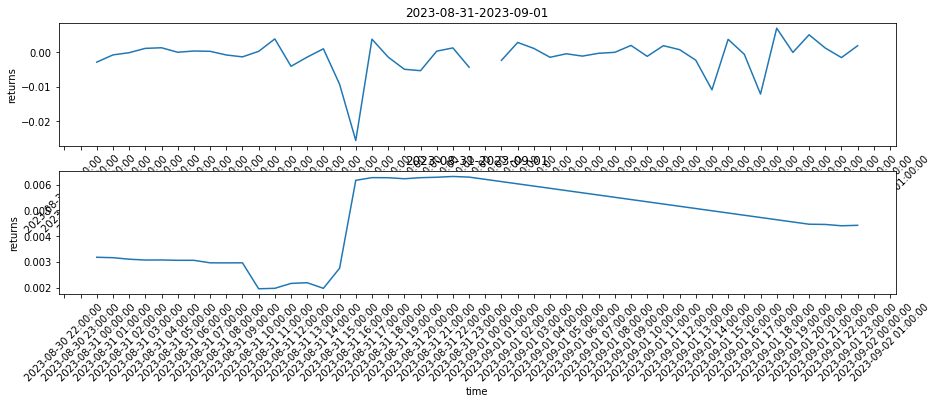

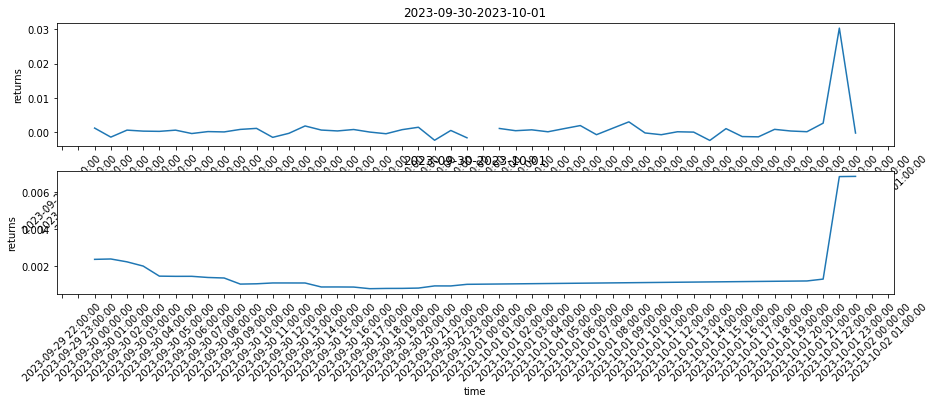

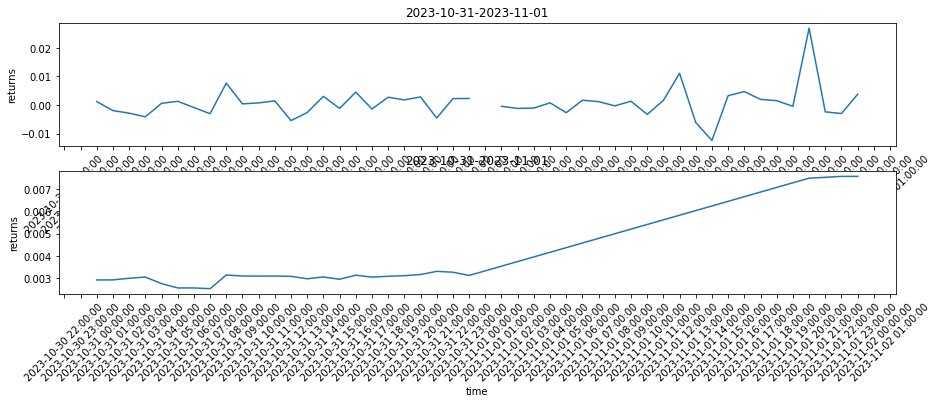

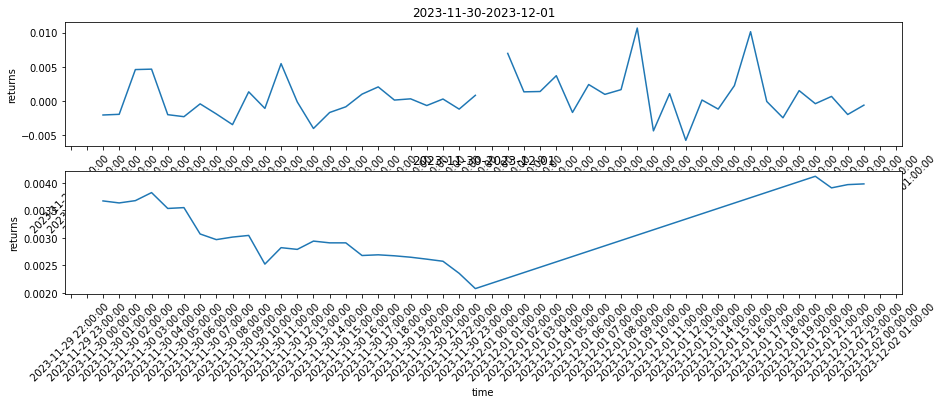

In [53]:
def Visualizing_returns(df, returns, start_date, end_date):
    
    df_filtered = df.loc[start_date:end_date]
    dfi_filtered = returns.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(df_filtered.index, df_filtered['returns'])
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].xaxis.set_major_locator(mdates.HourLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax[0].tick_params(axis='x', rotation=45)

    ax[1].plot(dfi_filtered.index, dfi_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    ax[1].xaxis.set_major_locator(mdates.HourLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()
    
Visualizing_returns(df, returns, '2023-01-31', '2023-02-01')
Visualizing_returns(df, returns, '2023-02-28', '2023-03-01')
Visualizing_returns(df, returns, '2023-03-31', '2023-04-01')
Visualizing_returns(df, returns, '2023-04-30', '2023-05-01')
Visualizing_returns(df, returns, '2023-05-31', '2023-06-01')
Visualizing_returns(df, returns, '2023-06-30', '2023-07-01')
Visualizing_returns(df, returns, '2023-08-31', '2023-09-01')
Visualizing_returns(df, returns, '2023-09-30', '2023-10-01')
Visualizing_returns(df, returns, '2023-10-31', '2023-11-01')
Visualizing_returns(df, returns, '2023-11-30', '2023-12-01')

In [60]:
df.dropna(inplace = True) # 임시

In [61]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rf_base(train_df, test_df, df_name=''): #df_name : 데이터 프레임 구분용, train_df 이름 기입
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor()

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)
    
    # 예측값 실제값 시각화
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(y_test.values, label='Actual', marker='o')
    ax.plot(y_pred, label='Predicted', marker='x')
    ax.set_title(f'{df_name} - Actual vs Predicted')
    ax.set_xlabel('Index')
    ax.set_ylabel('Volatility')
    ax.legend()
    plt.show()


    # 평가지표(MAPE, RMSE)
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')

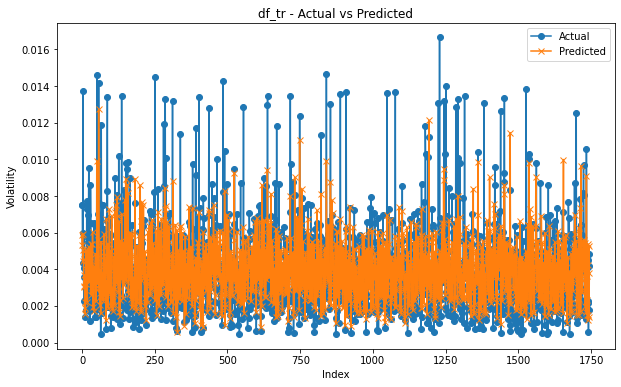

df_tr : MAPE: 41.961330225995226, RMSE: 0.0018759352926496836


In [65]:
# df 모델링
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
rf_base(df_tr, df_te, 'df_tr')

- 240124_세희 파일보다 MAPE, RMSE 증가